In [1]:
import os
import sys
import warnings

os.chdir("../..")
sys.path.append("../../")
warnings.filterwarnings("ignore")

# Simulate multi-omics data from single-omic data

## Introduction

In this example, we show how to use scDesign3Py to simulate multi-omics (RNA expression + DNA methylation) data by learning from real data that only have a single modality. The example data and aligned low-dimensional embeddings are from [Pamona](https://github.com/caokai1073/Pamona).

## Import packages and Read in data

### import pacakges


In [2]:
import anndata as ad
import pandas as pd
import scDesign3Py
import scanpy as sc

The R project used is located at /home/ld/anaconda3/envs/pyscdesign/lib/R


### Read in the reference data


In [3]:
meth_exp = ad.read_h5ad("data/SCGEMMETH.h5ad")
rna_exp = ad.read_h5ad("data/SCGEMRNA.h5ad")

## Simulation

We first use the step-by-step functions to fit genes’ marginal models, copulas, and extract simulation parameters separately for the scRNA-seq data and the DNA methylation data.

In [19]:
rna = scDesign3Py.scDesign3(n_cores=1,parallelization="mcmapply")
rna_data = rna.construct_data(
    anndata=rna_exp,
    default_assay_name="logcounts",
    celltype="cell_type",
    spatial=["UMAP1_integrated","UMAP2_integrated"],
    corr_formula="1"
)

In [22]:
meth = scDesign3Py.scDesign3(n_cores=1,parallelization="mcmapply")
meth_data = meth.construct_data(
    anndata=meth_exp,
    default_assay_name="counts",
    celltype="cell_type",
    spatial=["UMAP1_integrated", "UMAP2_integrated"],
    corr_formula="1",
)

Note here we actually treat the 2D aligned UMAPs as a kind of “pseudo”-spatial data. We use the tensor regression spline to fit two ref datasets seperately.

In [20]:
rna.set_r_random_seed(123)
rna_marginal = rna.fit_marginal(
    mu_formula="te(UMAP1_integrated, UMAP2_integrated, bs = 'cr', k = 10)",
    sigma_formula="te(UMAP1_integrated, UMAP2_integrated, bs = 'cr', k = 5)",
    family_use="gaussian",
    usebam=False,
)

In [23]:
meth.set_r_random_seed(123)
meth_marginal = meth.fit_marginal(
    mu_formula="te(UMAP1_integrated, UMAP2_integrated, bs = 'cr', k = 10)",
    sigma_formula="1",
    family_use="binomial",
    usebam=False,
)

In [21]:
rna_copula = rna.fit_copula(copula="vine")

R[write to console]: Convert Residuals to Uniform

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[wri

Time difference of 0.5472846 secs


R[write to console]: Vine Copula Estimation Ends



In [24]:
meth_copula = meth.fit_copula(copula="vine")

R[write to console]: Convert Residuals to Uniform

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[write to console]: Continuous gaussian doesnot need DT.

R[wri

Time difference of 0.3306446 secs


R[write to console]: Vine Copula Estimation Ends



In [25]:
rna_para = rna.extract_para(new_covariate=pd.concat([rna_data["dat"], meth_data["dat"]], axis=0))

In [26]:
meth_para = meth.extract_para(new_covariate=pd.concat([rna_data["dat"], meth_data["dat"]], axis=0))

Then, we combined the cell covariates from both the scRNA-seq data and the DNA methylation data as the new covariate to simulate the two new datasets with parameters from scRNA-seq data and the DNA methylation data separately.

In [27]:
rna_res = rna.simu_new(new_covariate=pd.concat([rna_data["dat"], meth_data["dat"]], axis=0),
                       important_feature=rna_copula["important_feature"],)

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



In [28]:
meth_res = meth.simu_new(new_covariate=pd.concat([rna_data["dat"], meth_data["dat"]], axis=0),
                         important_feature=meth_copula["important_feature"],)

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



## Visualization

We combine the two synthetic datasets and obtain the UMAP embeddings for the combined dataset.

In [29]:
count_combine = pd.concat([rna_res,meth_res], axis=1)
combine_exp = ad.AnnData(X=count_combine)

In [30]:
sc.tl.pca(combine_exp, n_comps=5)
sc.pp.neighbors(combine_exp, n_neighbors=30, n_pcs=5)
sc.tl.umap(combine_exp, min_dist=0.7)

In [31]:
rna_exp.obsm["cov"] = rna_exp.obs.iloc[:,0:5]
sc.pp.neighbors(rna_exp, n_neighbors=30, use_rep="cov")
sc.tl.umap(rna_exp, min_dist=0.7)

In [32]:
meth_exp.obsm["cov"] = meth_exp.obs.iloc[:,0:5]
sc.pp.neighbors(meth_exp, n_neighbors=30, use_rep="cov")
sc.tl.umap(meth_exp, min_dist=0.7)

Then we visualize the UMAP embeddings for the inputted scRNA-seq data, DNA methylation data, and the combined synthetic data.

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

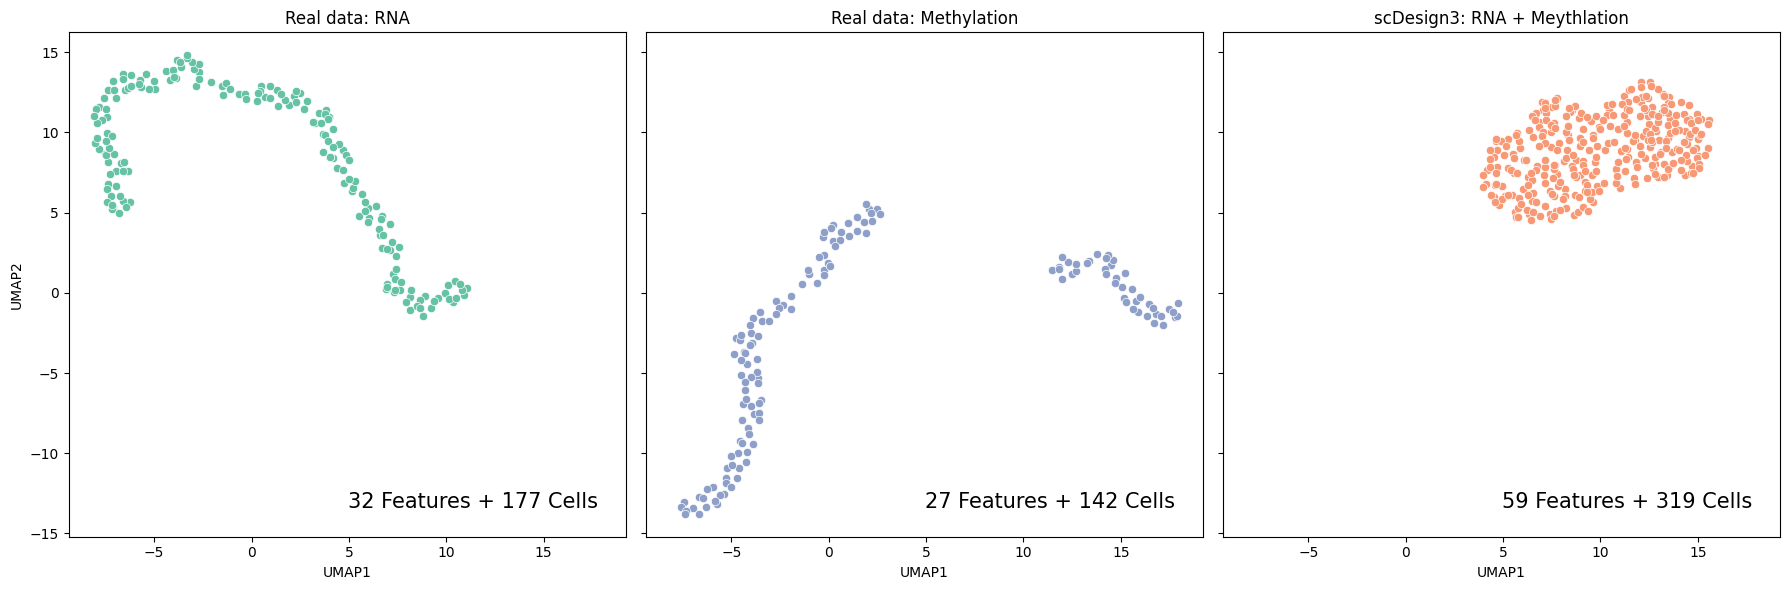

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

sns.scatterplot(data=pd.DataFrame(rna_exp.obsm["X_umap"],columns=["UMAP1","UMAP2"]), x="UMAP1", y="UMAP2", ax=axs[0], color = "#66c2a5")
axs[0].set_title("Real data: RNA")
axs[0].text(0.95, 0.05, "32 Features + 177 Cells", verticalalignment="bottom", horizontalalignment="right", transform=axs[0].transAxes, fontsize=15)

sns.scatterplot(data=pd.DataFrame(meth_exp.obsm["X_umap"],columns=["UMAP1","UMAP2"]), x="UMAP1", y="UMAP2", ax=axs[1], color = "#8ea0c9")
axs[1].set_title("Real data: Methylation")
axs[1].text(0.95, 0.05, "27 Features + 142 Cells", verticalalignment="bottom", horizontalalignment="right", transform=axs[1].transAxes, fontsize=15)

sns.scatterplot(data=pd.DataFrame(combine_exp.obsm["X_umap"],columns=["UMAP1","UMAP2"]), x="UMAP1", y="UMAP2", ax=axs[2], color = "#f79974")
axs[2].set_title("scDesign3: RNA + Meythlation")
axs[2].text(0.95, 0.05, "59 Features + 319 Cells", verticalalignment="bottom", horizontalalignment="right", transform=axs[2].transAxes, fontsize=15)

plt.tight_layout()
plt.show()